In [41]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import duckdb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
import umap
import nltk
import re
from sentence_transformers import SentenceTransformer

# Import from local modules
import sys
sys.path.append('../src')

from cleaning import minimal_clean
from clustering_analysis import cluster_with_umap_hdbscan, recluster_noise, print_cluster_examples, summarize_clusters, metacluster_preview

# Download necessary NLTK resources
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

# Path for 1 million English sample questions
load_dotenv()
coretopics_path = os.getenv("DATA_CORETOPICS")
coretopics_embeddings_path = os.getenv("DATA_CORETOPICS_EMBEDDINGS")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ruggb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ruggb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# load data
questions = pd.read_parquet(coretopics_path)

In [6]:
# Apply separate cleaning function that just normalizes spacing and removes very common "Q" boilerplate
questions['Q_basic_clean'] = questions['question_content'].apply(minimal_clean)

In [7]:
# Check if embeddings file exists

if os.path.exists(coretopics_embeddings_path):
    print("Embedding file exists — loading from disk.")
    data = np.load(coretopics_embeddings_path, allow_pickle=True)
    embeddings = data["embeddings"]
    question_ids = data["question_ids"]  # shouldn't be necessary, but saved just in case of a mix-up

else:
    print("Embedding file not found — generating embeddings.")
    model = SentenceTransformer('all-MiniLM-L6-v2')

    texts = questions['Q_basic_clean'].tolist()
    question_ids = questions['question_id'].to_numpy()

    embeddings = model.encode(
        texts,
        batch_size=64,
        show_progress_bar=True
    )
# Save embeddings to disk along with question IDs in case of mixup
    np.savez_compressed(coretopics_embeddings_path, embeddings=embeddings, question_ids=question_ids)
    print("Saved embeddings to disk.")

questions['embedding'] = list(embeddings)

Embedding file exists — loading from disk.


In [40]:
questions['question_topic'].value_counts()

question_topic
chicken    251160
cattle     238816
maize      184029
tomato     126708
Name: count, dtype: int64

### "Chicken" questions analysis

In [ ]:
chicken_df, chicken_umap, chicken_clusterer = cluster_with_umap_hdbscan(
    df=questions[questions['question_topic'] == 'chicken'],
    sample_size=1_000_000,
    umap_params={
        "n_neighbors": 30,
        "n_components": 5,
        "metric": "cosine",
        "random_state": 42
    },
    hdbscan_params={
        "min_cluster_size": 750,
        "min_samples": 10,
        "metric": "euclidean"
    }
)


In [ ]:
evaluate_clusters()

In [43]:
print_cluster_examples(chicken_df)


--- Cluster 20 (size=13109) ---
- how to start profitable kienyeji farm
- WHere can i get ready market 4 chicks
- Where Can I Get Young Chicks From?
- I want to know the rearing of one day old chick up to maturity
- Victor asks: Where can i get chicks za kuku kienyeji based in vihiga. Reply Q55 followed by your response.

--- Cluster 0 (size=4425) ---
- which vaccine given to hen that are at laying stage
- Which is the most vaccine 4controlling coccidiosis in chicknen
- HOW TO VACCINATE CHICKS UNDER TWO MANTHS
- HOW DO I USE MAREK VACINE IN ADULT HEN ?
- Godfrey asks: am serwada what is the good vaccine for chicks Reply Q359 followed by your response.

--- Cluster 19 (size=3480) ---
- HOW CAN I CONTROL A CHICKEN CHANGING HATBAHHNG PLACE
- I Have Been Keeping Paultry But The Chickens are die one after the other. how can i avoid it and what can I do please help me.
- When chicken makes crocking sound which disease? N medicine
- which is medicine of chicken?
- how many stept of treatment

,question_id,question_user_id,question_language,question_content,question_topic,question_sent,response_id,response_user_id,response_language,response_content,...,question_user_created_at,response_user_type,response_user_status,response_user_country_code,response_user_gender,response_user_dob,response_user_created_at,Q_basic_clean,embedding,cluster
90746,8356009,900985,eng,Q my chickens ''ina'ngorota sana''how do i con...,chicken,2018-08-08 10:14:00.887044+00,8356107,754008,eng,Q105 just use water that is mixd with papers,...,2018-06-09 12:42:10.298877+00,farmer,zombie,ke,None,None,2018-03-29 05:15:49.970627+00,my chickens ''ina'ngorota sana''how do i contr...,"[0.029005334, -0.0018736463, -0.024798797, 0.0...",52
136912,10014361,844815,eng,Q I have a chicken that is no longer laying ...,chicken,2018-08-29 18:48:24.244743+00,10014939,1072396,eng,Q9:When is no longer laying eggs it means it h...,...,2018-05-11 13:44:57.128045+00,farmer,destroyed,ke,None,None,2018-08-15 17:42:32.272909+00,I have a chicken that is no longer laying eggs,"[-0.0038265237, -0.06494584, 0.0098336805, -0....",45
53092,6473767,594639,eng,Q how many times can i give my chicks water pe...,chicken,2018-05-23 11:04:10.56714+00,6558428,21187,eng,Q357 clean water should be given throughout th...,...,2017-12-21 17:21:57+00,farmer,live,ke,male,1987-11-14,2015-09-17 15:22:50+00,how many times can i give my chicks water per day,"[0.0032430307, -0.032500714, 0.0029999781, 0.0...",9
1712,5126743,629210,eng,Q how can I increase the calcium content kwa c...,chicken,2018-03-12 05:06:32.180479+00,5139576,629349,eng,Q16 buy for them chicken mash,...,2018-01-18 17:39:44+00,farmer,zombie,ke,None,None,2018-01-18 17:40:27+00,how can I increase the calcium content kwa chi...,"[-0.024698595, -0.013664749, -0.028165495, 0.0...",0
737082,52895248,2923559,eng,Q can farmers help me raise so money to start ...,chicken,2021-01-28 06:32:55.596742+00,52902664,1276063,eng,Q488 NO,...,2020-02-27 16:23:17.057147+00,farmer,live,ke,None,None,2018-09-27 17:24:01.546289+00,can farmers help me raise so money to start ke...,"[-0.01221413, -0.03386621, -0.012488405, -0.00...",-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124703,10281575,1083302,eng,I w'd like to know wat causes e death of birds...,chicken,2018-09-03 12:53:55.861172+00,10291989,492432,eng,Q131MANY ILLNESES CAN AFFECT BIRDS BUT U HAVE ...,...,2018-08-20 12:43:40.339314+00,farmer,live,ug,None,None,2017-11-08 18:23:17+00,I w'd like to know wat causes e death of birds...,"[0.05824026, -0.014355156, 0.051266924, 0.0214...",-1
80568,6579063,880493,eng,Q chickens have problems on clearing their thr...,chicken,2018-05-27 09:53:06.60471+00,6579182,763929,eng,Q4.yes.they require continuous prevention afte...,...,2018-05-27 09:45:01.545935+00,farmer,zombie,ke,None,None,2018-04-05 17:17:01.198978+00,chickens have problems on clearing their throa...,"[0.010711151, -0.05345061, 0.02693319, 0.00696...",54
765094,56652978,3649538,eng,Q i am a small farmer planning to re...,chicken,2021-05-19 05:58:43.960648+00,56653454,3626799,eng,Q110 i have 1,...,2021-04-22 18:29:01.77852+00,farmer,live,ke,None,None,2021-04-08 16:55:00.566174+00,"i am a small farmer planning to rear chicks ,,...","[0.0059026717, -0.026331099, -0.023625549, -0....",57
207914,12083642,1223846,eng,Q. I have 2months old hens and noticed they a...,chicken,2018-09-26 17:00:46.847093+00,12084540,1112499,swa,091.WAWEKEE.AMOXIRIN.KWA.MAJI.PIA.UWAPATIE.DAW...,...,2018-09-20 04:59:52.372365+00,farmer,zombie,ke,None,None,2018-08-22 18:00:22.708441+00,I have 2months old hens and noticed they are s...,"[0.08368256, -0.072374195, 0.019832283, 0.0138...",-1


In [31]:
noise_df = chicken_df[chicken_df['cluster'] == -1]
noise_df, noise_umap, noise_clusterer = cluster_with_umap_hdbscan(
    df=noise_df,
    sample_size=100_000,
    umap_params={
        "n_neighbors": 30,
        "n_components": 5,
        "metric": "cosine",
        "random_state": 42
    },
    hdbscan_params={
        "min_cluster_size": 100,
        "min_samples": 10,
        "metric": "euclidean"
    }
)


Finished clustering in 24.6 seconds
Noise ratio: 36.87%
Clusters found: 62


In [32]:
print_cluster_examples(noise_df)


--- Cluster 54 (size=1434) ---
- am keeping hens en there a dying ov chickhen disease hw u help me&wat a sm of da medicine i cn treat them with
- Which type of break disease cause hens to die a few minutes
- One of my chick is opening and closing the mouth,what measures to take2 prevent others from this?
- how do i konw that a hen is sick
- my hens is eating much what is the problem

--- Cluster 11 (size=1178) ---
- So what is the reliable temperature here in western? I lost more than 50chickens in December even after I had vaccinated before they died.
- my chicken house destroyed by rain so I need seaport
- How can you detect signs of heat on hen
- ,is electricity very necessary during hatching days in chicks?
- How can i make a local heater in my hen's house?

--- Cluster 49 (size=909) ---
- I would like to start rearing chickens and i dont have capital to start then project,how can WEFARM assist me to start?
- which chickens I can rare in embu county
- ;with a small project of five

In [24]:
for row in summarize_clusters(chicken_df, extra_stop_words = ('chicken', 'chickens', 'hen', 'hens', 'chiken', 'chiks', 'chics')).sort_values(by = 'size', ascending = False).itertuples(index=False):
    print(f"Cluster {row.cluster} (size={row.size}): {row.keywords}")


Cluster -1 (size=29185): eggs, chicks, lay, cock, chick
Cluster 20 (size=13109): kienyeji, chicks, chick, improved, old
Cluster 0 (size=4425): vaccine, chicks, vaccinate, vaccination, vaccines
Cluster 19 (size=3480): medicine, diseases, disease, treat, sick
Cluster 7 (size=2824): broilers, broiler, layers, market, best
Cluster 9 (size=2765): chicks, feed, food, feeds, best
Cluster 2 (size=2675): layers, layer, best, good, mash
Cluster 42 (size=2593): eggs, lay, laying, problem, egg
Cluster 16 (size=2153): start, keeping, want, type, best
Cluster 26 (size=2089): long, does, eggs, lay, laying
Cluster 21 (size=1762): medicine, chicks, chick, use, best
Cluster 1 (size=1753): best, food, start, feed, type
Cluster 28 (size=1718): eyes, chicks, wounds, swollen, eye
Cluster 27 (size=1662): eyes, eye, swollen, wounds, disease
Cluster 23 (size=1617): chicks, die, dying, death, problem
Cluster 6 (size=1551): coughing, cough, sneezing, medicine, flue
Cluster 18 (size=1383): feed, food, feeds, best

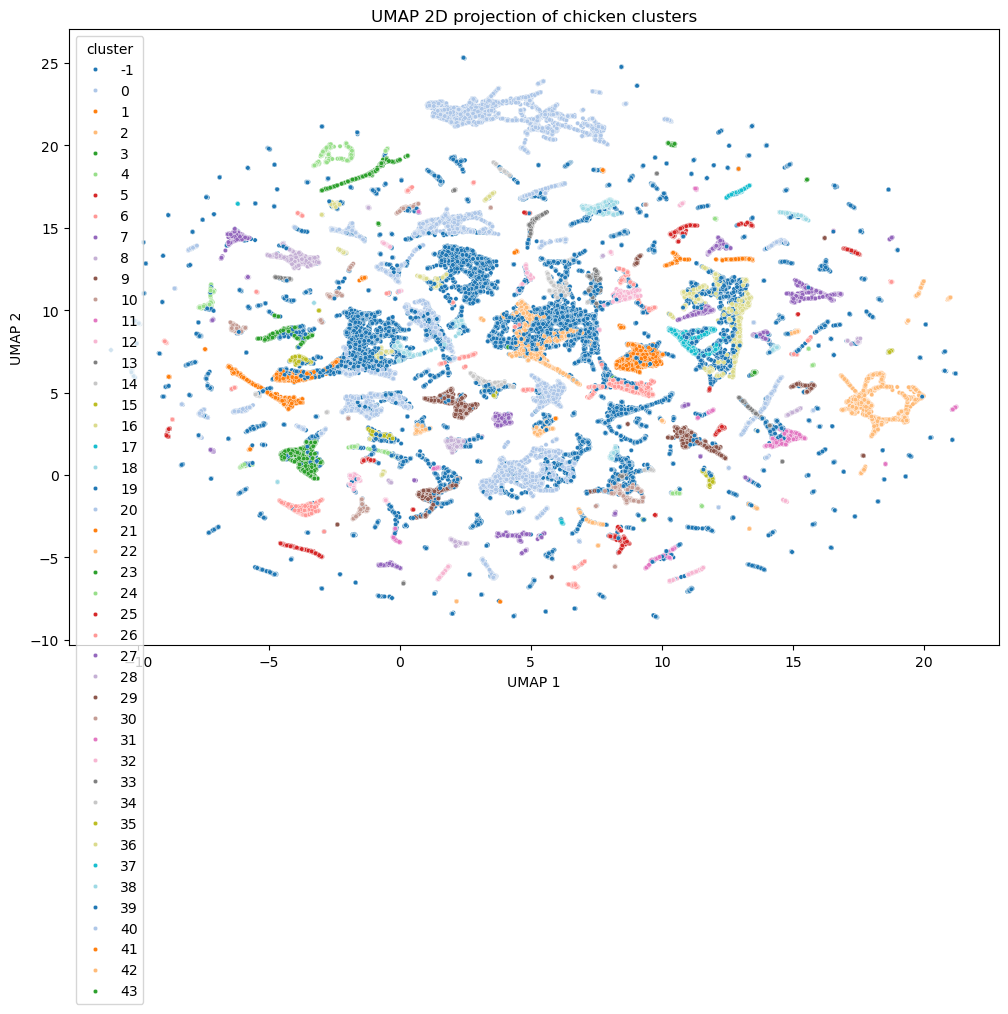

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume chicken_umap is an array of shape (n_samples, 5)
# Reduce to 2D for plotting
import umap

reducer_2d = umap.UMAP(n_components=2, random_state=42)
umap_2d = reducer_2d.fit_transform(chicken_umap)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_2d[:, 0], y=umap_2d[:, 1], hue=chicken_df['cluster'], 
                palette='tab20', legend='full', s=10)
plt.title("UMAP 2D projection of chicken clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


In [1]:
cluster_counts = chicken_df['cluster'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Cluster ID")
plt.ylabel("Number of Questions")
plt.title("Cluster Sizes")
plt.show()


NameError: name 'chicken_df' is not defined

### "Maize" questions analysis


In [ ]:
maize_df, maize_umap, maize_clusterer = cluster_with_umap_hdbscan(
    df=questions[questions['question_topic'] == 'maize'],
    sample_size=1_000_000,
    umap_params={
        "n_neighbors": 30,
        "n_components": 5,
        "metric": "cosine",
        "random_state": 42
    },
    hdbscan_params={
        "min_cluster_size": 750,
        "min_samples": 10,
        "metric": "euclidean"
    }
)